# Predicting ASD diagnosis from Genetic Data

0/1 classification with logistic regression is a well-studied problem.  In order to familiarize myself with standard logistic regression techniques, I'm going to start with the simple two-class classification problem of predicting ASD/non-ASD diagnosis from genotype.

Author: Rachael Caelie "Rocky" Aikens

Created: Oct 25, 2017

Version: 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score, make_scorer, roc_curve
import random


## Data preprocessing

We have genotype information for siblings from the Agre and Simons Simplex Collection, which has been featurized into a binary matrix (described below). In addition to that, we have imputed ASD/non-ASD labels and ADOS/ADI-R scores for a subset of those individuals.

### Feature Data (Genotype)

The input data is represented as a binary matrix.  There are a couple different representations we can use here, but to start I will use 1 = loss of function variant(compound het or homozygous alternate), 0 = no loss of function variant.

In [4]:
# load input feature dataset for Agre
Agre_asd = pd.read_csv("data/v34_lof_asd_af0.50.txt", index_col=0).transpose()
Agre_ctrl = pd.read_csv("data/v34_lof_typical_af0.50.txt", index_col=0).transpose()

print("Cases: ", Agre_asd.shape[0])
print("Controls: ", Agre_ctrl.shape[0])

Cases:  1616
Controls:  349


In [5]:
# load input feature dataset for SSC
SSC_asd = pd.read_csv("data/SSC_lof_asd_af0.50.txt", index_col=0).transpose()
SSC_ctrl = pd.read_csv("data/SSC_lof_typical_af0.50.txt", index_col=0).transpose()

print ("Cases: ", SSC_asd.shape[0])
print ("Controls: ", SSC_ctrl.shape[0])

Cases:  517
Controls:  518


In [6]:
# merge SSC and Agre data
X_asd = pd.concat([SSC_asd, Agre_asd], axis = 0).fillna(0)
X_ctrl = pd.concat([SSC_ctrl, Agre_ctrl], axis = 0).fillna(0)

In [7]:
X = pd.concat([X_asd, X_ctrl], axis=0)
print ("Total cases: ", X_asd.shape[0])
print ("Total controls: ", X_ctrl.shape[0])
print ("Features (ie. genes): ", X.shape[1])
print ("Missing Values: ", int(X.isnull().values.any()))

Total cases:  2133
Total controls:  867
Features (ie. genes):  1109
Missing Values:  0


### Target Data (ASD/non-ASD diagnosis)

We have a file that Kelley has made with inferred Autism/Control diagnosis for the individuals in the iHart study.  We will try and predict diagnosis 0 = Control, 1 = Austism.

In [8]:
y = pd.read_csv("data/all_samples_filtered_labels.csv", usecols = ['identifier','diagnosis'], index_col=0)

In [9]:
# shift y to a 0/1 representation for Control/ASD
y["diagnosis"] = np.where(y['diagnosis'] == 'Autism', 1, 0)

In [10]:
print("Cases: ", np.sum(y == 1))
print("Controls: ", np.sum(y == 0))

Cases:  diagnosis    11510
dtype: int64
Controls:  diagnosis    1983
dtype: int64


### Filtering for Overlap

Our phenotype labels y may not perfectly overlap with our genotype data, X.

In [70]:
# get lists of individuals in X and Y
m_x = X.index.values.tolist()
m_x_asd = X_asd.index.tolist()
m_x_ctrl = X_ctrl.index.tolist()
m_y = y.index.values.tolist()

# check subject overlap between X and Y
print ("%d subjects in X are not in y.  Of these, %d are cases and %d are controls." % (len(set(m_x) - set(m_y)), len(set(m_x_asd) - set(m_y)), len(set(m_x_ctrl) - set(m_y))))

# make a list of Subject IDs with overlap
subjects = list(set(m_x) & set(m_y))
print ("This leaves %d subjects: %d cases and %d controls." % (len(subjects), len(set(m_x_asd) & set(m_y)), len(set(m_x_ctrl)&set(m_y))) )

868 subjects in X are not in y.  Of these, 5 are cases and 863 are controls.
This leaves 2132 subjects: 2128 cases and 4 controls.


**Note:** The set of "cases" and "controls" appear to be differently defined between the iHart Phenotype labels (i.e. our `y` labels) and the CGT matrix labels (i.e. our `X` features). 

You can notice that the majority of controls don't appear in our phenotype information dataset. This is because ADOS\ADI-R was not administered to many controls from SSC and Agre. Since we're interested in classifying ASD/non-ASD, for our purposes it is not necessary to exclude these individuals because we do not necessarily need any phenotype information outside of diagnosis. Rather, we can infer that all individuals in a 'control' CGT matrix without ADOS/ADI-R information have a non-ASD diagnosis.

In [71]:
to_add = list(set(m_x_ctrl) - set(m_y))
y_ctrl = pd.DataFrame(np.zeros(len(to_add),), columns = ['diagnosis'],index = to_add)
y = pd.concat([y, y_ctrl], axis = 0)
subjects = subjects + to_add
print (len(subjects))
print (y.shape)

2995
(14356, 1)


In [1]:
# redefine X and Y to contain only the subjects we want
X = X.iloc[subjects]
y = y.iloc[subjects]

# check we have the same subject IDs in the same order for X and Y
print( y.index.values.tolist() == X.index.values.tolist())
y = y.iloc[:,0]
print (y.value_counts())

NameError: name 'X' is not defined

One thing that's probably going to be an issue for this experiment is that there are very few controls for whom we have both genetic and ADOS/ADI-R information.  This is going to mean that a random classifier performs with fairly high accuracy, just because classifying most or all individuals as autistic is a effective strategy when we have so few negatives. 

## Data Splitting

Since we have ~1,600 examples, I'm going to hold out 20% of the data as a test set and then do 5 fold cross validation using built-in sklearn methods.

In [73]:
random.seed(143)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Note, we could do this splitting by family id using model_selection.GroupKFold
#>>> group_kfold = GroupKFold(n_splits=2)
#>>> group_kfold.get_n_splits(X, y, groups)
#groups = pair id
#BUT rocky's class should work (not on my local machine) well

In [103]:
import class_ReadData
from class_ReadData import getData

X_train, X_test, y_train, y_test = getData()

NameError: name 'pd' is not defined

## Logistic Regression

### Model and training parameters

I am going to implement logistic regression using sklearn.

We'll start with the following parameters:

**Cost function**
- Penalty distance metric = $L_2$
- Dual formulation = `False` (better when $m$ > $n$)
- c ($\frac{1}{\lambda}$ for regularization) = 1

**Optimization Algorithm**
- tolerance for convergence = $1\times 10^{-4}$
- optimization algorithm = liblinear

**Model definition**
- fit_intercept = `True`
- class weighting = None
- multi_class = 'ovr'

More or less, these are the sklearn defaults, which I can tune at a later point.

I've built a python object called EvalLR which will help me run cross validation for my regression models and output plots and statistics.  The following code initializes an EvalLR with the logistic regression model described above:

In [74]:
# Import EvalLR
imp.reload(class_EvalLR)
imp.reload(class_SibKFold)

from class_EvalLR import EvalLR

### First-pass 5-fold cross validation

To start, I'm going to run 5-fold cross validation on the training set. The following code does the necessary split for the data and prints the train and test scores for each fold using the f1 scoring metric.  Recall that this is:

$$F_1 = \frac{2}{\frac{1}{r} + \frac{1}{p}} = \frac{2rp}{r + p},$$

where $r$ represents the *recall* or *sensitivity* of the classification and $p$ represents the *precision*. 

In [75]:
evalr = EvalLR(X_train, y_train, reg = 'l2')

In [76]:
tmp = list(range(0,10))
print(tmp)
tmp2 = [i for i in tmp if i!= 0]



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



Running cross validation for fold 1:
Train Score: 0.859464 Test Score: 0.550097
AU-ROC 0.550096961862

Optimum threshold to maximize training accuracy: 0.531173509388
F1: 0.766859344894
Accuracy: 0.646198830409
Confusion Matrix:
 [[ 22  82]
 [ 39 199]]


C:\Users\Christine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Optimum threshold to maximize f1: 0.530301406399
F1: 0.766859344894
Accuracy: 0.646198830409
Confusion Matrix:
 [[ 22  82]
 [ 39 199]]
None


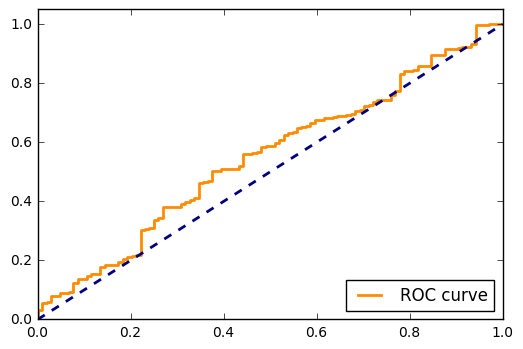


Running cross validation for fold 2:
Train Score: 0.866985 Test Score: 0.486552
AU-ROC 0.486551764115

Optimum threshold to maximize training accuracy: 0.575900557677
F1: 0.682008368201
Accuracy: 0.555555555556
Confusion Matrix:
 [[ 27  86]
 [ 66 163]]

Optimum threshold to maximize f1: 0.493787037141
F1: 0.716
Accuracy: 0.584795321637
Confusion Matrix:
 [[ 21  92]
 [ 50 179]]
None


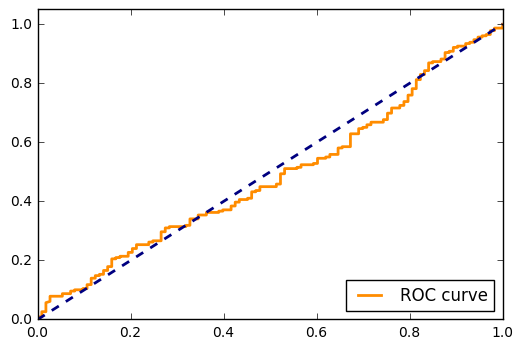


Running cross validation for fold 3:
Train Score: 0.867737 Test Score: 0.532954
AU-ROC 0.532954165273

Optimum threshold to maximize training accuracy: 0.561198184099
F1: 0.7261663286
Accuracy: 0.605263157895
Confusion Matrix:
 [[ 28  70]
 [ 65 179]]

Optimum threshold to maximize f1: 0.52784286844
F1: 0.739130434783
Accuracy: 0.614035087719
Confusion Matrix:
 [[ 23  75]
 [ 57 187]]
None


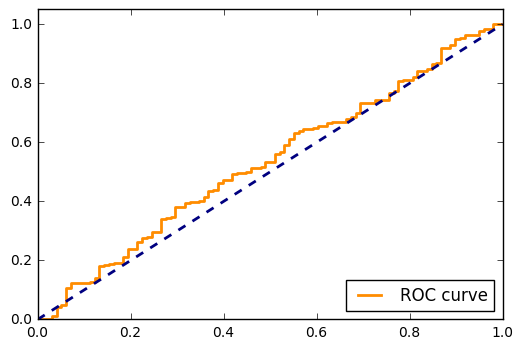


Running cross validation for fold 4:
Train Score: 0.856317 Test Score: 0.581385
AU-ROC 0.581384628279

Optimum threshold to maximize training accuracy: 0.547887485084
F1: 0.777777777778
Accuracy: 0.673469387755
Confusion Matrix:
 [[ 35  62]
 [ 50 196]]

Optimum threshold to maximize f1: 0.547887485084
F1: 0.777777777778
Accuracy: 0.673469387755
Confusion Matrix:
 [[ 35  62]
 [ 50 196]]
None


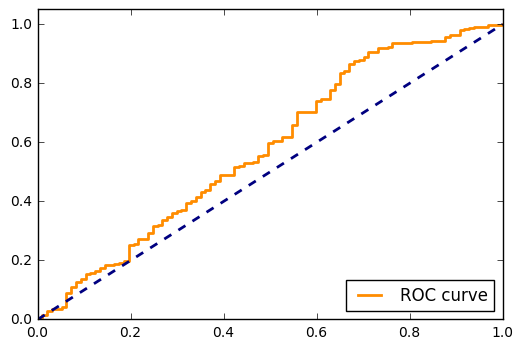


Running cross validation for fold 5:
Train Score: 0.863949 Test Score: 0.551837
AU-ROC 0.55183747822

Optimum threshold to maximize training accuracy: 0.559747924348
F1: 0.75
Accuracy: 0.632653061224
Confusion Matrix:
 [[ 28  79]
 [ 47 189]]

Optimum threshold to maximize f1: 0.540503592529
F1: 0.757396449704
Accuracy: 0.64139941691
Confusion Matrix:
 [[ 28  79]
 [ 44 192]]
None


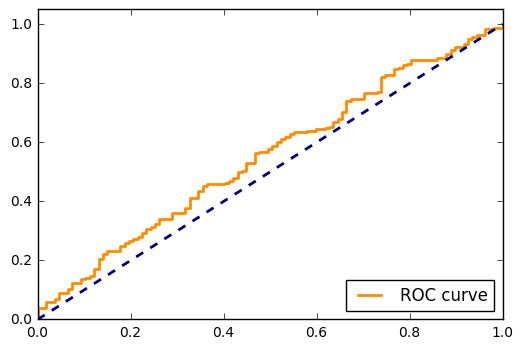


Running cross validation for fold 6:
Train Score: 0.854993 Test Score: 0.577159
AU-ROC 0.577158999193

Optimum threshold to maximize training accuracy: 0.539279657024
F1: 0.732106339468
Accuracy: 0.615835777126
Confusion Matrix:
 [[ 31  74]
 [ 57 179]]

Optimum threshold to maximize f1: 0.537239563724
F1: 0.734693877551
Accuracy: 0.618768328446
Confusion Matrix:
 [[ 31  74]
 [ 56 180]]
None


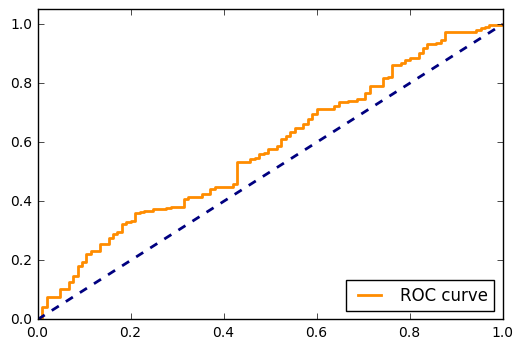


Running cross validation for fold 7:
Train Score: 0.863347 Test Score: 0.562924
AU-ROC 0.56292356186

Optimum threshold to maximize training accuracy: 0.599782710886
F1: 0.732217573222
Accuracy: 0.626822157434
Confusion Matrix:
 [[ 40  68]
 [ 60 175]]

Optimum threshold to maximize f1: 0.480821966133
F1: 0.76245210728
Accuracy: 0.638483965015
Confusion Matrix:
 [[ 20  88]
 [ 36 199]]
None


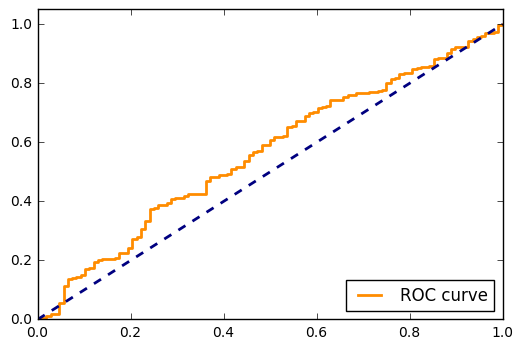

In [77]:
scores, topvals = evalr.kfold(7, True)

Below are the training and testing F1 scores for each fold of cross validation:

In [78]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print ("Test:", np.mean(scores.Test_score))

  Train_score Test_score
1    0.859464   0.550097
2    0.866985   0.486552
3    0.867737   0.532954
4    0.856317   0.581385
5    0.863949   0.551837
6    0.854993   0.577159
7    0.863347   0.562924
Train: 0.861827595292
Test: 0.548986794114


In addition to training a predictive model, we'd also like to be able to make inference about which of the features in our CGT matrix are most informative for predicting Austism status.  The following are the top 10 genes with the greatest average odds ratios (i.e. farthest from 1). In order to make statistical inference, however, we should calculate a Wald statistic for each feature and search for the most significantly predictive features using multiple hypothesis testing correction.

In [79]:
print(topvals)

['C5orf27', 'CDH15', 'RP11-738O11.13', 'ABCB7', 'AC093911.1', 'RP11-283G6.4', 'GBGT1', 'VCX3A']


## Regularization

Since our testing performance f1-scores are still about .1 below our training scores, it makes some sense to look into tuning our regularization parameter $C$ to avoid overfit.  I've written a function below, `reg_plot`, which performs 5 fold cross validation for models with different values of $C$.  

**Note** Recall that $C$ is the inverse of the cannonical regularization parameter, $\lambda$, so that smaller $C$ corresponds to stronger regularization.

In [80]:
# create a plot of preformance versus f1 score for different c values
def reg_plot(c_vals, X_train, y_train, resample = False):
    c_scores = []
    print( "Running 7-fold cross validation for:")
    for i in range(len(c_vals)):
        #print "C = %f" % c_vals[i]
        evalr = EvalLR(X_train, y_train, reg = 'l2', c = c_vals[i])
        c_scores.append(np.mean(evalr.kfold(7, False, False, resample)[0].Test_score))

    plt.clf()
    plt.ylabel('Feature 2')
    plt.xlabel('Feature 1')
    plt.plot(c_vals, c_scores, linestyle = '-')
    plt.show()
    plt.figure(figsize=(10,10))
    return c_vals[c_scores.index(max(c_scores))]

Running 7-fold cross validation for:


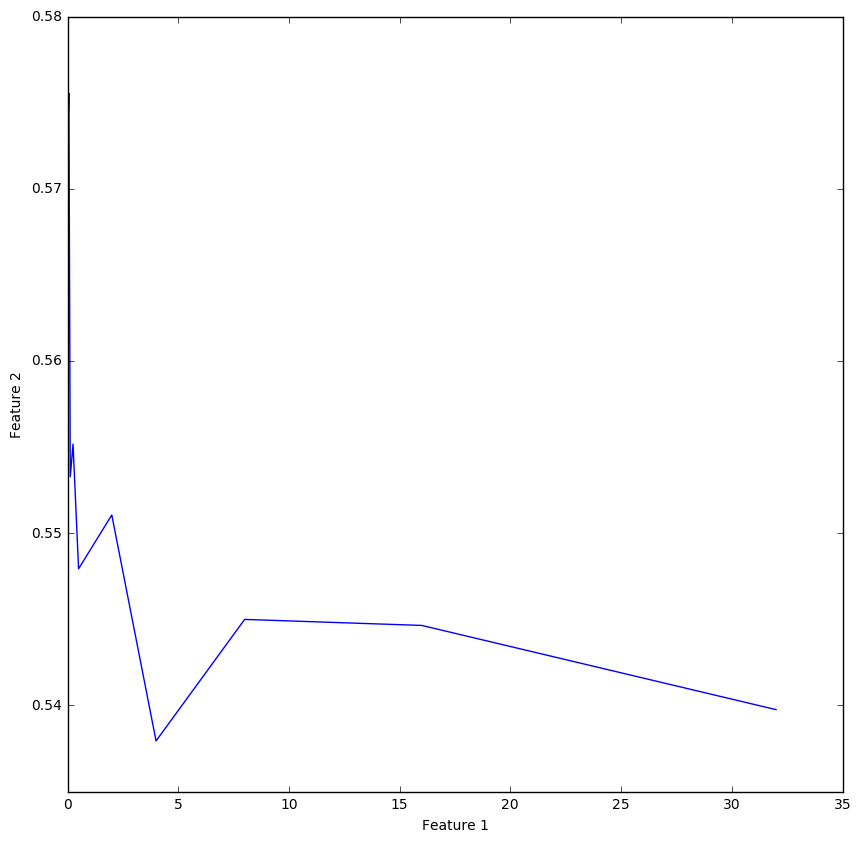

In [81]:
c_vals = [2**5, 2**4, 2**3, 2**2, 2, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5]
c_opt = reg_plot(c_vals, X_train, y_train)

At a first pass, it seems like lower regularization parameters may increase performance on the testing set.  Let's zoom in on performance for $C \leq 1$ (since 1 is the default value we've previously been using):

Running 7-fold cross validation for:


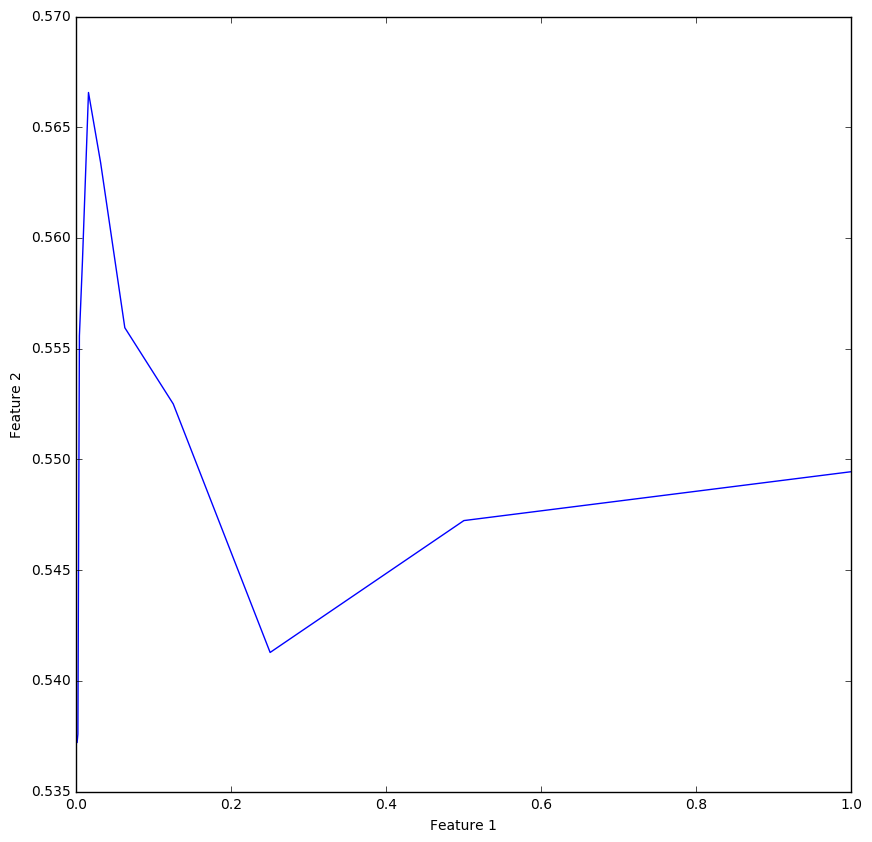

In [82]:
c_vals = [1, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5, 2**-6, 2**-7, 2**-8, 2**-9, 2**-10]
c_opt = reg_plot(c_vals, X_train, y_train)

These results suggest that stronger regularization may improve performance.  Let's try again with a stronger regularization (the max of the plot above).


Running cross validation for fold 1:
Train Score: 0.748210 Test Score: 0.548608
AU-ROC 0.548608103319

Optimum threshold to maximize training accuracy: 0.631822136066
F1: 0.777777777778
Accuracy: 0.66081871345
Confusion Matrix:
 [[ 23  86]
 [ 30 203]]


C:\Users\Christine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Optimum threshold to maximize f1: 0.628477128396
F1: 0.790960451977
Accuracy: 0.675438596491
Confusion Matrix:
 [[ 21  88]
 [ 23 210]]
None


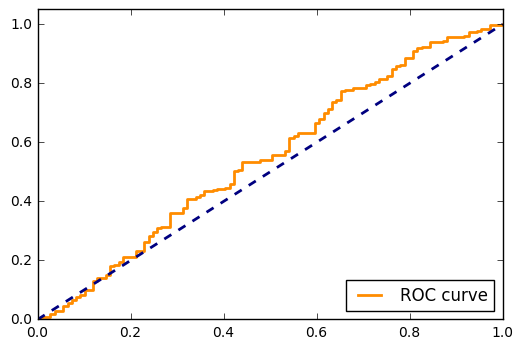


Running cross validation for fold 2:
Train Score: 0.744374 Test Score: 0.549020
AU-ROC 0.549020365576

Optimum threshold to maximize training accuracy: 0.632756650022
F1: 0.777777777778
Accuracy: 0.66081871345
Confusion Matrix:
 [[ 23  90]
 [ 26 203]]

Optimum threshold to maximize f1: 0.611963343819
F1: 0.802218114603
Accuracy: 0.687134502924
Confusion Matrix:
 [[ 18  95]
 [ 12 217]]
None


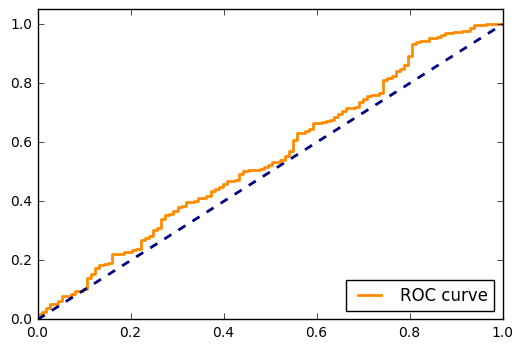


Running cross validation for fold 3:
Train Score: 0.750305 Test Score: 0.577655
AU-ROC 0.577655228758

Optimum threshold to maximize training accuracy: 0.633491185213
F1: 0.796992481203
Accuracy: 0.684210526316
Confusion Matrix:
 [[ 22  80]
 [ 28 212]]

Optimum threshold to maximize f1: 0.628830406138
F1: 0.8
Accuracy: 0.684210526316
Confusion Matrix:
 [[ 18  84]
 [ 24 216]]
None


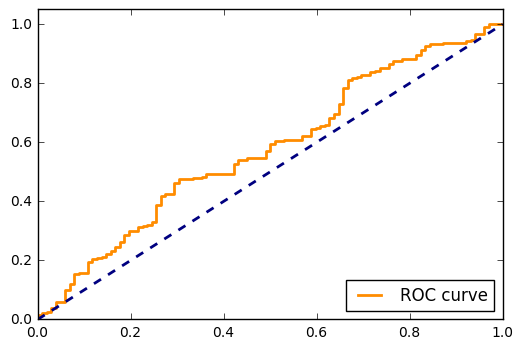


Running cross validation for fold 4:
Train Score: 0.745505 Test Score: 0.572901
AU-ROC 0.572901142573

Optimum threshold to maximize training accuracy: 0.623645798239
F1: 0.805147058824
Accuracy: 0.690962099125
Confusion Matrix:
 [[ 18  81]
 [ 25 219]]

Optimum threshold to maximize f1: 0.615474341083
F1: 0.807272727273
Accuracy: 0.690962099125
Confusion Matrix:
 [[ 15  84]
 [ 22 222]]
None


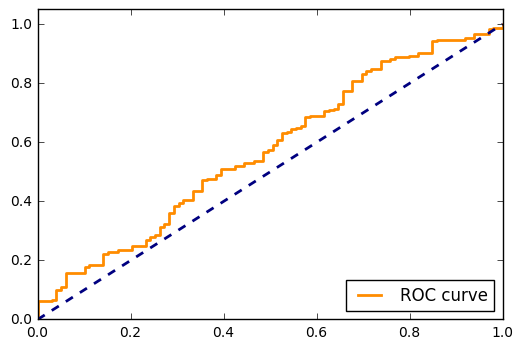


Running cross validation for fold 5:
Train Score: 0.748864 Test Score: 0.565559
AU-ROC 0.565559440559

Optimum threshold to maximize training accuracy: 0.634356268103
F1: 0.779850746269
Accuracy: 0.656976744186
Confusion Matrix:
 [[ 17  93]
 [ 25 209]]

Optimum threshold to maximize f1: 0.622149380933
F1: 0.807207207207
Accuracy: 0.688953488372
Confusion Matrix:
 [[ 13  97]
 [ 10 224]]
None


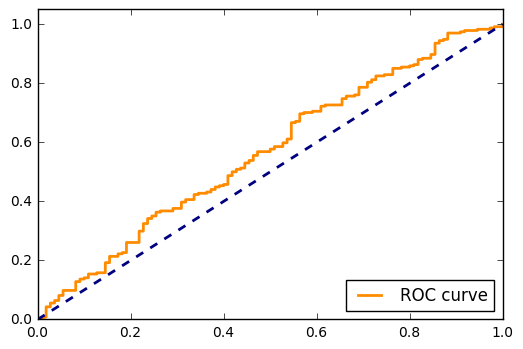


Running cross validation for fold 6:
Train Score: 0.750122 Test Score: 0.535138
AU-ROC 0.535137701804

Optimum threshold to maximize training accuracy: 0.632415343712
F1: 0.776515151515
Accuracy: 0.654970760234
Confusion Matrix:
 [[ 19  89]
 [ 29 205]]

Optimum threshold to maximize f1: 0.605213113748
F1: 0.807142857143
Accuracy: 0.684210526316
Confusion Matrix:
 [[  8 100]
 [  8 226]]
None


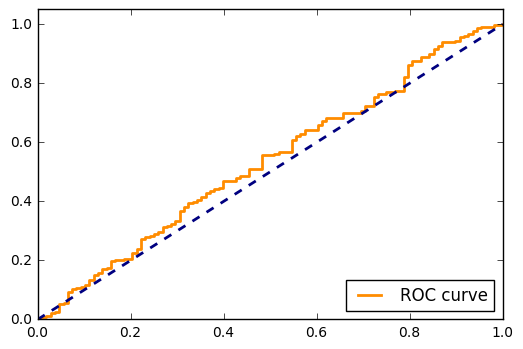


Running cross validation for fold 7:
Train Score: 0.750865 Test Score: 0.567429
AU-ROC 0.567428571429

Optimum threshold to maximize training accuracy: 0.625208479854
F1: 0.808043875686
Accuracy: 0.692082111437
Confusion Matrix:
 [[ 15  76]
 [ 29 221]]

Optimum threshold to maximize f1: 0.61351827264
F1: 0.826475849732
Accuracy: 0.715542521994
Confusion Matrix:
 [[ 13  78]
 [ 19 231]]
None


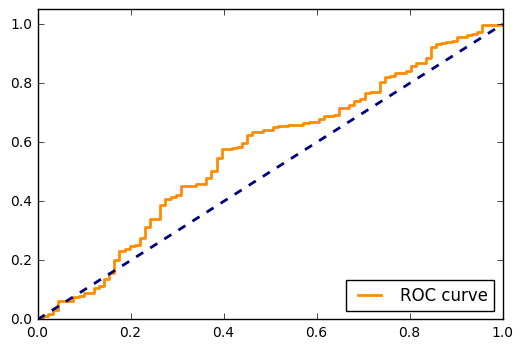

In [83]:
evalr = EvalLR(X_train, y_train, reg = 'l2', c = c_opt)
scores, topgenes = evalr.kfold(7, True)

In [85]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print( "Test:", np.mean(scores.Test_score))

  Train_score Test_score
1     0.74821   0.548608
2    0.744374    0.54902
3    0.750305   0.577655
4    0.745505   0.572901
5    0.748864   0.565559
6    0.750122   0.535138
7    0.750865   0.567429
Train: 0.748320633372
Test: 0.559472936288


In [86]:
print (topgenes)

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-86-3c8694453030>, line 1)

## Resampling data to address class imbalance

Right now, we have a class imbalance problem because we tend to have many more autistic than non-autistic people in our dataset.  In general, we currently have two autistic subjects for every control subject in our training set:

In [87]:
y_train.value_counts()

1.0    1664
0.0     732
Name: diagnosis, dtype: int64

One approach to address this problem is to resample from our data so that there is a 1:1 raio between austistic subjects and non-autistic controls.  In this implementation, I oversample the neurotypical subjects; that is, the positive subjects in the training data remain the same, but I sample with replacement from the neurotypical subjects in the training set for each fold so that there are as many controls as ASD cases in both the training and testing sets.

Now we can retrain our model with resampled data:

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 1:
Train Score: 0.896455 Test Score: 0.579484
AU-ROC 0.579483824314

Optimum threshold to maximize training accuracy: 0.501639140501
F1: 0.579654510557
Accuracy: 0.545643153527
Confusion Matrix:
 [[112 129]
 [ 90 151]]


C:\Users\Christine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Optimum threshold to maximize f1: 0.477987068213
F1: 0.588679245283
Accuracy: 0.547717842324
Confusion Matrix:
 [[108 133]
 [ 85 156]]
None


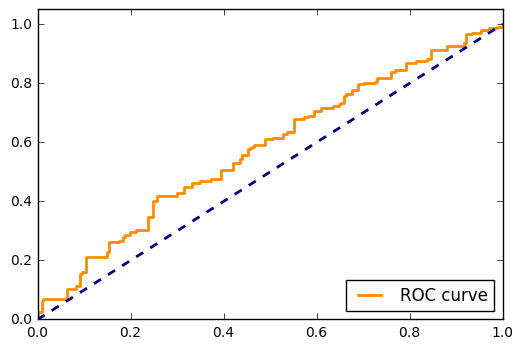

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 2:
Train Score: 0.904438 Test Score: 0.541749
AU-ROC 0.541749197459

Optimum threshold to maximize training accuracy: 0.474065759478
F1: 0.625678119349
Accuracy: 0.572314049587
Confusion Matrix:
 [[104 138]
 [ 69 173]]

Optimum threshold to maximize f1: 0.473277935225
F1: 0.625678119349
Accuracy: 0.572314049587
Confusion Matrix:
 [[104 138]
 [ 69 173]]
None


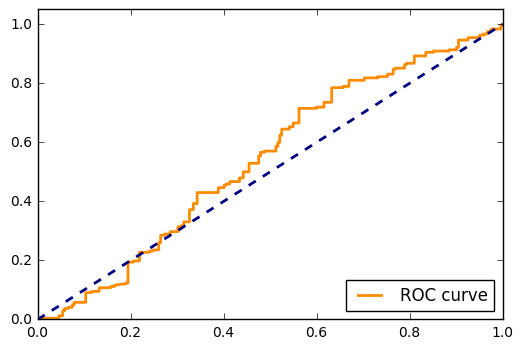

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 3:
Train Score: 0.903606 Test Score: 0.544908
AU-ROC 0.544908320549

Optimum threshold to maximize training accuracy: 0.534301366815
F1: 0.581132075472
Accuracy: 0.525641025641
Confusion Matrix:
 [[ 92 142]
 [ 80 154]]

Optimum threshold to maximize f1: 0.429164186116
F1: 0.614864864865
Accuracy: 0.512820512821
Confusion Matrix:
 [[ 58 176]
 [ 52 182]]
None


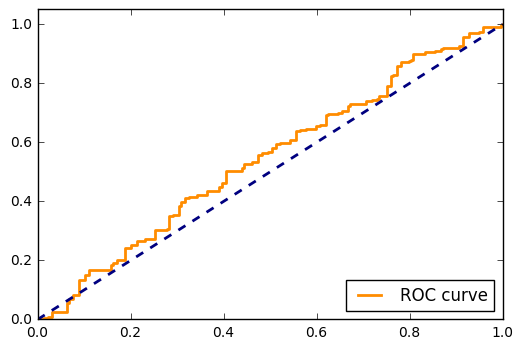

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 4:
Train Score: 0.905603 Test Score: 0.474694
AU-ROC 0.47469443187

Optimum threshold to maximize training accuracy: 0.482847756152
F1: 0.544444444444
Accuracy: 0.476595744681
Confusion Matrix:
 [[ 77 158]
 [ 88 147]]

Optimum threshold to maximize f1: 0.478222270269
F1: 0.547134935305
Accuracy: 0.478723404255
Confusion Matrix:
 [[ 77 158]
 [ 87 148]]
None


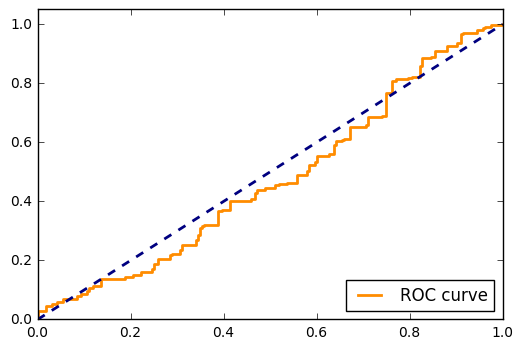

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 5:
Train Score: 0.905390 Test Score: 0.539536
AU-ROC 0.53953626635

Optimum threshold to maximize training accuracy: 0.502017778342
F1: 0.605714285714
Accuracy: 0.553879310345
Confusion Matrix:
 [[ 98 134]
 [ 73 159]]

Optimum threshold to maximize f1: 0.502017778342
F1: 0.605714285714
Accuracy: 0.553879310345
Confusion Matrix:
 [[ 98 134]
 [ 73 159]]
None


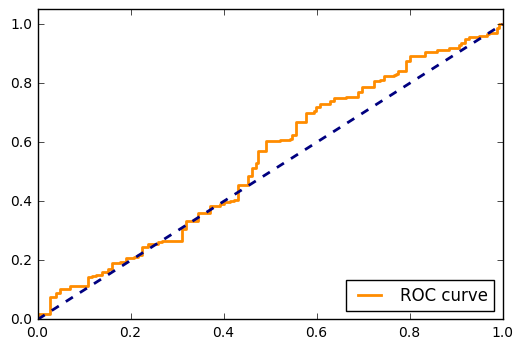

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 6:
Train Score: 0.898340 Test Score: 0.539040
AU-ROC 0.53904030578

Optimum threshold to maximize training accuracy: 0.508402813441
F1: 0.540337711069
Accuracy: 0.491701244813
Confusion Matrix:
 [[ 93 148]
 [ 97 144]]

Optimum threshold to maximize f1: 0.445357704746
F1: 0.575971731449
Accuracy: 0.502074688797
Confusion Matrix:
 [[ 79 162]
 [ 78 163]]
None


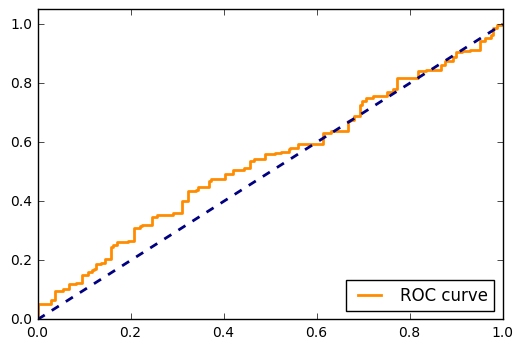

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 7:
Train Score: 0.901619 Test Score: 0.540502
AU-ROC 0.540501741916

Optimum threshold to maximize training accuracy: 0.482360370499
F1: 0.591397849462
Accuracy: 0.523012552301
Confusion Matrix:
 [[ 85 154]
 [ 74 165]]

Optimum threshold to maximize f1: 0.429126843924
F1: 0.603773584906
Accuracy: 0.516736401674
Confusion Matrix:
 [[ 71 168]
 [ 63 176]]
None


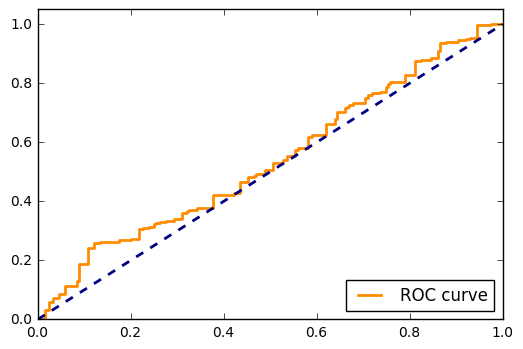

  Train_score Test_score
1    0.896455   0.579484
2    0.904438   0.541749
3    0.903606   0.544908
4    0.905603   0.474694
5     0.90539   0.539536
6     0.89834    0.53904
7    0.901619   0.540502
['GCSAML', 'CDH15', 'C5orf27', 'AC093911.1', 'RP11-283G6.4', 'ABCB7', 'VCX3A', 'GBGT1']


In [89]:
evalr = EvalLR(X_train, y_train, reg = 'l2')
scores, topgenes = evalr.kfold(7, makeROC = True, resample = True); print (scores); print (topgenes)

After resampling, the ROC curves look about the same.  The average training score is increased, and the average testing error is about the same as before resampling with this regularization parameter. 

We can tune the regularization parameter as we did before:

Running 7-fold cross validation for:


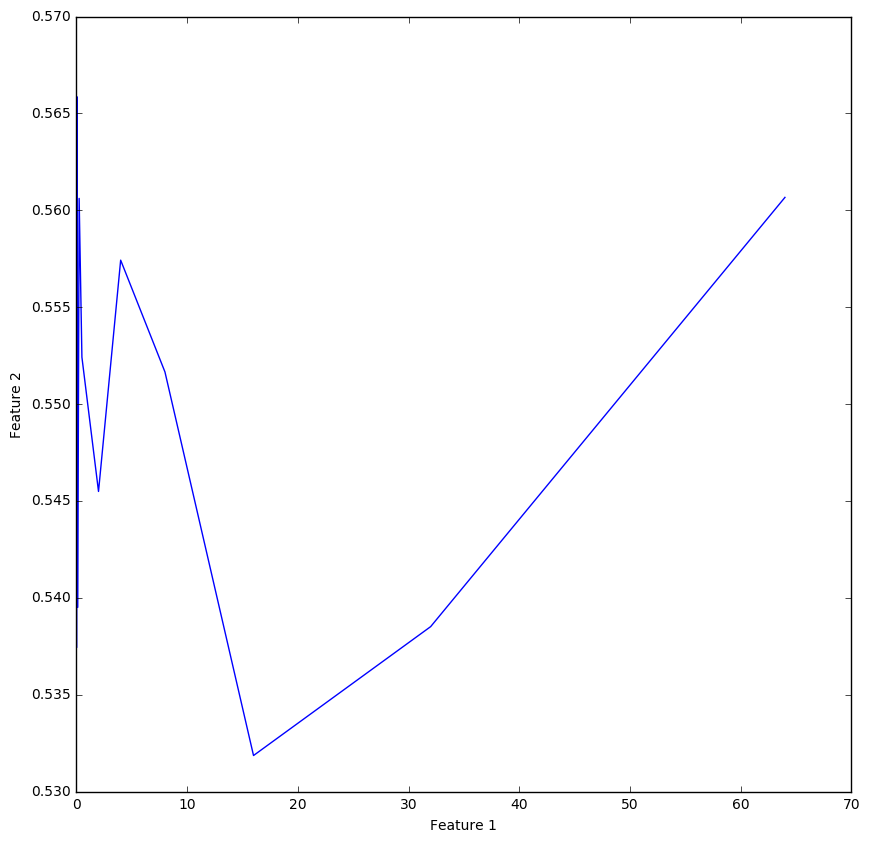

0.0625

In [90]:
c_vals = [2**6, 2**5, 2**4, 2**3, 2**2, 2, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5]
reg_plot(c_vals, X_train, y_train, resample = True)

Running 7-fold cross validation for:


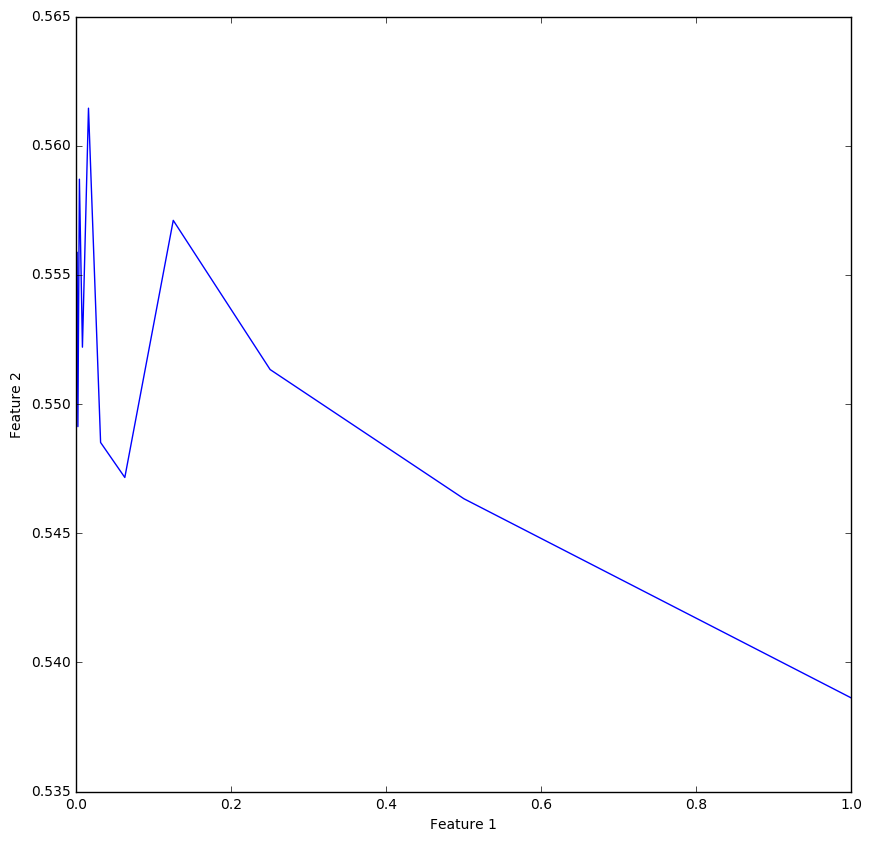

In [91]:
c_vals = [1, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5, 2**-6, 2**-7, 2**-8, 2**-9, 2**-10]
c_opt = reg_plot(c_vals, X_train, y_train, resample = True)

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 1:
Train Score: 0.792721 Test Score: 0.527660
AU-ROC 0.527659853464

Optimum threshold to maximize training accuracy: 0.503575467863
F1: 0.561467889908
Accuracy: 0.516194331984
Confusion Matrix:
 [[102 145]
 [ 94 153]]


C:\Users\Christine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Optimum threshold to maximize f1: 0.467117500304
F1: 0.613636363636
Accuracy: 0.518218623482
Confusion Matrix:
 [[ 67 180]
 [ 58 189]]
None


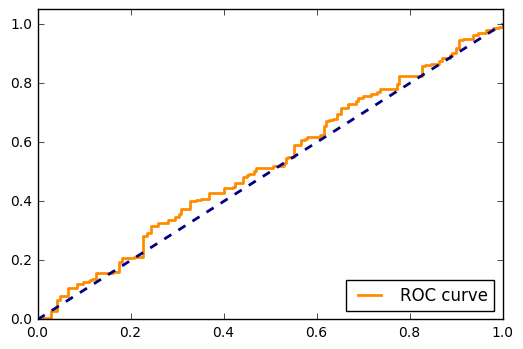

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 2:
Train Score: 0.790853 Test Score: 0.576339
AU-ROC 0.576338666082

Optimum threshold to maximize training accuracy: 0.483456258641
F1: 0.609665427509
Accuracy: 0.551282051282
Confusion Matrix:
 [[ 94 140]
 [ 70 164]]

Optimum threshold to maximize f1: 0.474435012582
F1: 0.625678119349
Accuracy: 0.557692307692
Confusion Matrix:
 [[ 88 146]
 [ 61 173]]
None


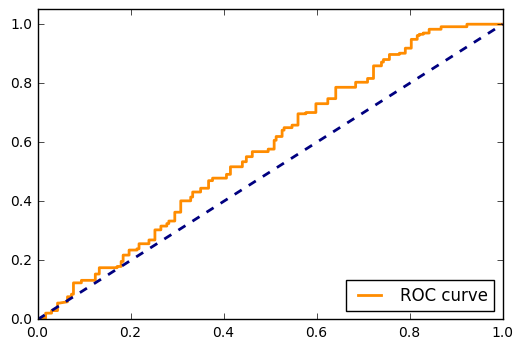

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 3:
Train Score: 0.789708 Test Score: 0.561335
AU-ROC 0.561334608292

Optimum threshold to maximize training accuracy: 0.496292745733
F1: 0.590990990991
Accuracy: 0.530991735537
Confusion Matrix:
 [[ 93 149]
 [ 78 164]]

Optimum threshold to maximize f1: 0.479796617627
F1: 0.618803418803
Accuracy: 0.539256198347
Confusion Matrix:
 [[ 80 162]
 [ 61 181]]
None


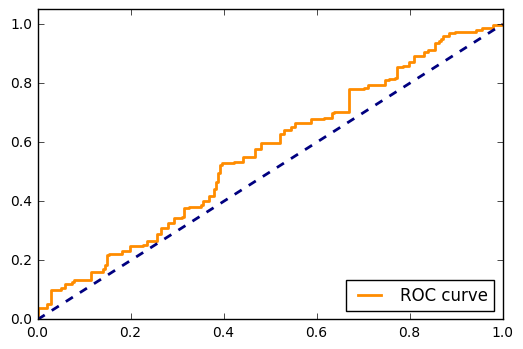

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 4:
Train Score: 0.791041 Test Score: 0.546689
AU-ROC 0.546689209275

Optimum threshold to maximize training accuracy: 0.504682289105
F1: 0.559837728195
Accuracy: 0.532327586207
Confusion Matrix:
 [[109 123]
 [ 94 138]]

Optimum threshold to maximize f1: 0.442132013169
F1: 0.634920634921
Accuracy: 0.504310344828
Confusion Matrix:
 [[ 34 198]
 [ 32 200]]
None


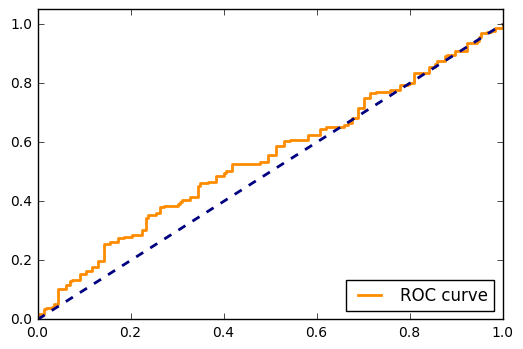

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 5:
Train Score: 0.785064 Test Score: 0.603837
AU-ROC 0.603837490897

Optimum threshold to maximize training accuracy: 0.491027739193
F1: 0.616755793226
Accuracy: 0.557613168724
Confusion Matrix:
 [[ 98 145]
 [ 70 173]]

Optimum threshold to maximize f1: 0.449947325088
F1: 0.685624012638
Accuracy: 0.590534979424
Confusion Matrix:
 [[ 70 173]
 [ 26 217]]
None


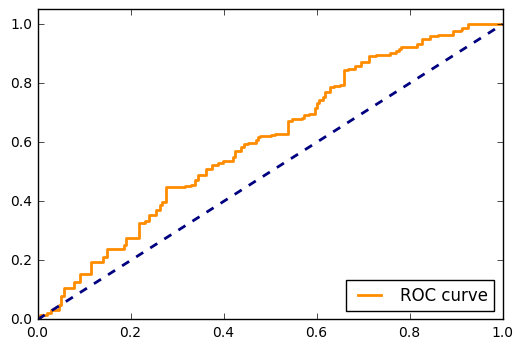

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 6:
Train Score: 0.800393 Test Score: 0.536073
AU-ROC 0.53607254775

Optimum threshold to maximize training accuracy: 0.493063489459
F1: 0.594202898551
Accuracy: 0.531380753138
Confusion Matrix:
 [[ 90 149]
 [ 75 164]]

Optimum threshold to maximize f1: 0.467961504968
F1: 0.642740619902
Accuracy: 0.541841004184
Confusion Matrix:
 [[ 62 177]
 [ 42 197]]
None


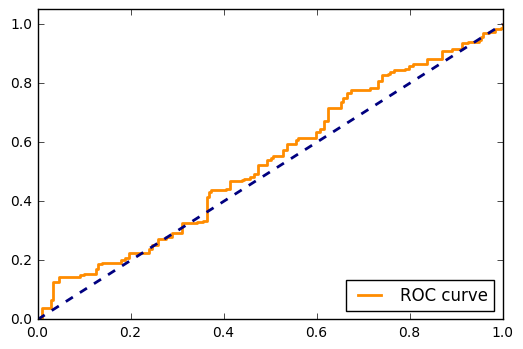

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 7:
Train Score: 0.797826 Test Score: 0.586524
AU-ROC 0.586524093229

Optimum threshold to maximize training accuracy: 0.50785899947
F1: 0.561555075594
Accuracy: 0.552863436123
Confusion Matrix:
 [[121 106]
 [ 97 130]]

Optimum threshold to maximize f1: 0.469931743966
F1: 0.635547576302
Accuracy: 0.552863436123
Confusion Matrix:
 [[ 74 153]
 [ 50 177]]
None


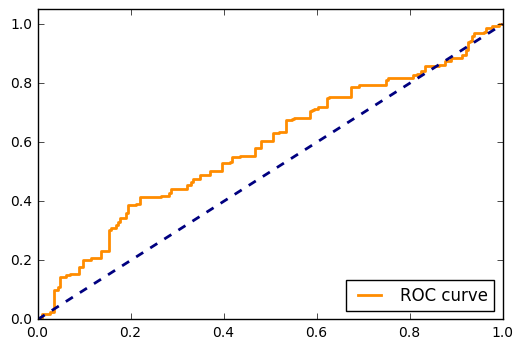

  Train_score Test_score
1    0.792721    0.52766
2    0.790853   0.576339
3    0.789708   0.561335
4    0.791041   0.546689
5    0.785064   0.603837
6    0.800393   0.536073
7    0.797826   0.586524
['MAGEE2', 'OR51I2', 'CTB-23I7.1', 'AC023115.1', 'AP002856.6', 'CSAG1', 'RP11-404K5.2', 'VCX3A']


In [93]:
evalr = EvalLR(X_train, y_train, reg = 'l2', c = c_opt)
scores, topgenes = evalr.kfold(7, makeROC = True, resample = True); print (scores); print (topgenes)

## Improvements

The following changes might be good to think about:
- continue to improve EvalLR for fine-tuning regression models.
- get wald statistic to detect important features
- try other regression methods
- is f1 score the best method when class imbalance is high?  Maybe I should be using AU-ROC or AU-PRC.
- tune regularization parameter to try and reduce the variance we have
- upsample to avoid class imbalance
- split train/test data based on family ID just like sibkfold
- add precision-recall


- What happened to the beautiful numbers Rocky was showing in lab meeting?
- Use kfoldgroup to clean up the way we split by family ID
- make sure all scripts are compatible with python3